<a href="https://colab.research.google.com/github/Nekhaenko/text_classification/blob/main/text%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.2 MB/s eta 0:00:00


In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
import pandas as pd
import numpy as np
import re
import joblib
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# Load data
dataset = load_dataset("dair-ai/emotion")
df_train = pd.DataFrame(dataset['train'])
df_valid = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
df_train.head()

,text,label
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3


In [10]:
# Count the number of instances for each class in each part of dataset
values, counts_train = np.unique(dataset['train']['label'], return_counts=True)
_, counts_valid = np.unique(dataset['validation']['label'], return_counts=True)
_, counts_test = np.unique(dataset['test']['label'], return_counts=True)
pd.DataFrame({'label': values, 
              'train': counts_train,
              'valid': counts_valid,
              'test': counts_test})

,label,train,valid,test
0,0,4666,550,581
1,1,5362,704,695
2,2,1304,178,159
3,3,2159,275,275
4,4,1937,212,224
5,5,572,81,66


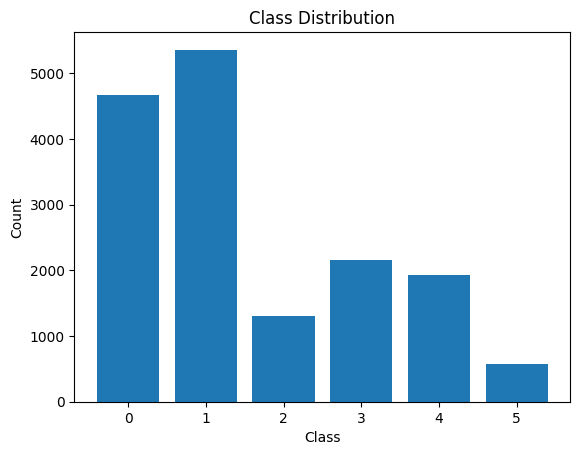

In [11]:
# Count the number of instances for each class
class_counts = df_train['label'].value_counts()

# Plot the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

We have a class imbalance. Perhaps we will perform class balancing.

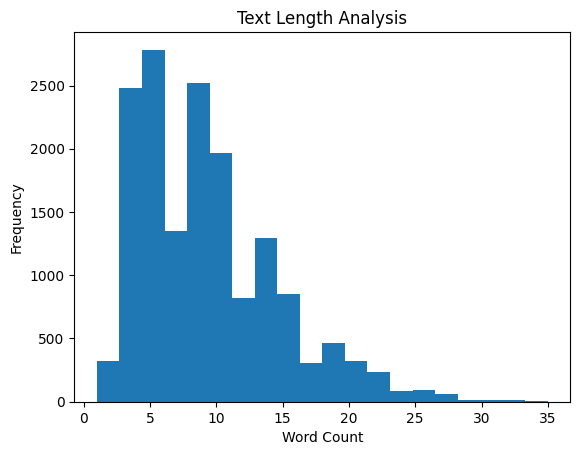

In [ ]:
# Calculate the number of words in each document
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.hist(df_train['word_count'], bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Text Length Analysis')
plt.show()

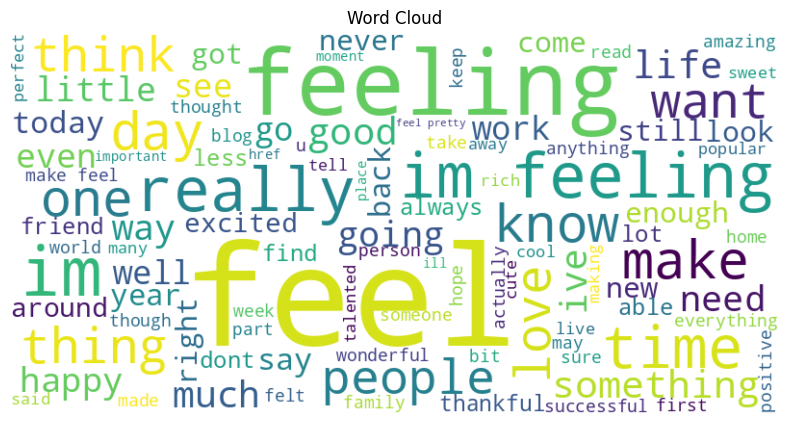

In [15]:
# Create a word cloud of the most common words in 1 class
class_one = df_train['text'][df_train['label']==1]
wordcloud = WordCloud(width=800, height=400, max_words=100, 
                      background_color='white').generate(' '.join(class_one))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

vectorizer = CountVectorizer()
tf_matrix = vectorizer.fit_transform(class_one)

word_frequencies = zip(vectorizer.get_feature_names_out(), tf_matrix.sum(axis=0).tolist()[0])
sorted_word_frequencies = sorted(word_frequencies, key=lambda x: x[1], reverse=True)

In [4]:
# Preprocess the text
def preprocess_text(text):
    # Remove special characters and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    # Join the words back into a single string
    processed_text = ' '.join(filtered_text)
    return processed_text

In [5]:
# Apply preprocessing to the text column
df_train['text'] = df_train['text'].apply(preprocess_text)
df_valid['text'] = df_valid['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [6]:
df_models_quality = pd.DataFrame(columns = ['model name', 'train accuracy', 
                                            'valid accuracy', 'test accuracy'])
model_id = 0

In [7]:
# Build baseline model

In [7]:
base_line_model = Pipeline([('cv', CountVectorizer()), 
                  ('lr', LogisticRegression(random_state=10))])

base_line_model.fit(df_train.text, df_train.label)
y_pred = base_line_model.predict(df_train.text)
train_accuracy = metrics.accuracy_score(df_train.label, y_pred)

y_pred = base_line_model.predict(df_valid.text)
valid_accuracy = metrics.accuracy_score(df_valid.label, y_pred)

y_pred = base_line_model.predict(df_test.text)
test_accuracy = metrics.accuracy_score(df_test.label, y_pred)

df_models_quality.loc[model_id] = ['baseline model cv', train_accuracy, 
                                   valid_accuracy, test_accuracy]

df_models_quality

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model name,train accuracy,valid accuracy,test accuracy
0,baseline model cv,0.985437,0.8975,0.891


In [8]:
print(classification_report(df_test.label, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       581
           1       0.91      0.93      0.92       695
           2       0.77      0.76      0.77       159
           3       0.88      0.87      0.88       275
           4       0.85      0.86      0.85       224
           5       0.82      0.62      0.71        66

    accuracy                           0.89      2000
   macro avg       0.86      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
# tuned model

In [9]:
tuned_model = Pipeline([('cv', CountVectorizer(ngram_range=(1, 2),
                                                   min_df=4)), 
                  ('lr', LogisticRegression(random_state=10, 
                                            class_weight='balanced'))])

tuned_model.fit(df_train.text, df_train.label)
y_pred = tuned_model.predict(df_train.text)
train_accuracy = metrics.accuracy_score(df_train.label, y_pred)

y_pred = tuned_model.predict(df_valid.text)
valid_accuracy = metrics.accuracy_score(df_valid.label, y_pred)

y_pred = tuned_model.predict(df_test.text)
test_accuracy = metrics.accuracy_score(df_test.label, y_pred)
model_id += 1
df_models_quality.loc[model_id] = ['tuned model', train_accuracy, 
                                   valid_accuracy, test_accuracy]

df_models_quality

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model name,train accuracy,valid accuracy,test accuracy
0,baseline model cv,0.985437,0.8975,0.891
1,tuned model,0.979812,0.9080,0.899


In [10]:
print(classification_report(df_test.label, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       581
           1       0.96      0.89      0.92       695
           2       0.73      0.90      0.80       159
           3       0.87      0.91      0.89       275
           4       0.89      0.83      0.86       224
           5       0.66      0.88      0.75        66

    accuracy                           0.90      2000
   macro avg       0.84      0.89      0.86      2000
weighted avg       0.91      0.90      0.90      2000



In [12]:
# Random Forest model

In [11]:
rf_model = Pipeline([('cv', CountVectorizer(ngram_range=(1, 2),
                                                   min_df=4)), 
                  ('lr', RandomForestClassifier(random_state=10, 
                                                class_weight ='balanced'))])

rf_model.fit(df_train.text, df_train.label)
y_pred = rf_model.predict(df_train.text)
train_accuracy = metrics.accuracy_score(df_train.label, y_pred)

y_pred = rf_model.predict(df_valid.text)
valid_accuracy = metrics.accuracy_score(df_valid.label, y_pred)

y_pred = rf_model.predict(df_test.text)
test_accuracy = metrics.accuracy_score(df_test.label, y_pred)
model_id += 1
df_models_quality.loc[model_id] = ['CV RF model', train_accuracy, 
                                   valid_accuracy, test_accuracy]

df_models_quality

,model name,train accuracy,valid accuracy,test accuracy
0,baseline model cv,0.985437,0.8975,0.8910
1,tuned model,0.979812,0.9080,0.8990
2,CV RF model,0.997500,0.8875,0.8785


In [12]:
print(classification_report(df_test.label, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       581
           1       0.91      0.89      0.90       695
           2       0.72      0.82      0.77       159
           3       0.87      0.91      0.89       275
           4       0.86      0.86      0.86       224
           5       0.57      0.76      0.65        66

    accuracy                           0.88      2000
   macro avg       0.82      0.85      0.83      2000
weighted avg       0.89      0.88      0.88      2000



In [24]:
# Perform class balancing

In [13]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=4)
cv_train = cv.fit_transform(df_train['text'])

In [14]:
ros = RandomOverSampler(random_state = 42)
X_train_resample, y_train_resample = ros.fit_resample(cv_train, df_train['label'])
print("Original Data: ", Counter(df_train['label']))
print("After Under Sampling: ", Counter(y_train_resample))

Original Data:  Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
After Under Sampling:  Counter({0: 5362, 3: 5362, 2: 5362, 5: 5362, 4: 5362, 1: 5362})


In [15]:
balanced_model = LogisticRegression(random_state=10)
balanced_model.fit(X_train_resample, y_train_resample)

y_pred = balanced_model.predict(X_train_resample)
train_accuracy = metrics.accuracy_score(y_train_resample, y_pred)

X_valid = cv.transform(df_valid['text'])
y_pred = balanced_model.predict(X_valid)
valid_accuracy = metrics.accuracy_score(df_valid.label, y_pred)

X_test = cv.transform(df_test['text'])
y_pred = balanced_model.predict(X_test)
test_accuracy = metrics.accuracy_score(df_test.label, y_pred)
model_id += 1
df_models_quality.loc[model_id] = ['balanced model', train_accuracy, 
                                   valid_accuracy, test_accuracy]

df_models_quality

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model name,train accuracy,valid accuracy,test accuracy
0,baseline model cv,0.985437,0.8975,0.8910
1,tuned model,0.979812,0.9080,0.8990
2,CV RF model,0.997500,0.8875,0.8785
3,balanced model,0.992323,0.9035,0.9015


In [16]:
print(classification_report(df_test.label, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       581
           1       0.96      0.90      0.93       695
           2       0.74      0.89      0.81       159
           3       0.87      0.90      0.89       275
           4       0.90      0.84      0.87       224
           5       0.68      0.89      0.77        66

    accuracy                           0.90      2000
   macro avg       0.85      0.89      0.87      2000
weighted avg       0.91      0.90      0.90      2000



In [25]:
pth = '/content/drive/MyDrive/models/'
joblib.dump(cv, f'{pth}cv.m')
joblib.dump(balanced_model, f'{pth}balanced_model.m')

['/content/drive/MyDrive/models/balanced_model.m']

In [26]:
cv_txt = joblib.load(f'{pth}cv.m')
model = joblib.load(f'{pth}balanced_model.m')

In [33]:
df_test['text'][:1]

0    im feeling rather rotten im ambitious right
Name: text, dtype: object

In [31]:
%%time
test = cv_txt.transform(df_test['text'][:1])
y_pred = model.predict(test)

CPU times: user 1.78 ms, sys: 0 ns, total: 1.78 ms
Wall time: 8.81 ms


In [32]:
%%time
test = cv_txt.transform(df_test['text'])
y_pred = model.predict(test)

CPU times: user 63.7 ms, sys: 0 ns, total: 63.7 ms
Wall time: 139 ms


In [29]:
df_models_quality.to_excel(f'{pth}df_models_quality.xlsx', index=False)

Transformer model

In [1]:
pip install datasets transformers onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 117.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 8.4 MB/s eta 0:00:00


In [3]:
import torch
from datasets import load_dataset
import pandas as pd
from sklearn import metrics
from transformers import pipeline
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          BertForSequenceClassification,
                          TrainingArguments, Trainer)

In [ ]:
from onnxruntime.quantization import (
    quantize_dynamic,
    QuantType
)

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.rand(1).cuda()

tensor([0.8985], device='cuda:0')

In [5]:
max_seq_length = 512
model_name = 'j-hartmann/emotion-english-distilroberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)


def tokenize_function(examples):
    return tokenizer(examples["text"],
                     return_tensors='pt',
                     max_length= max_seq_length,
                     truncation=True,
                     padding='max_length')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    metr = metrics.accuracy_score(predictions.tolist(), labels.tolist())
    return {'accuracy': metr}

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at j-hartmann/emotion-english-distilroberta-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.4.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.5.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.2.attention.self.query.bias', 'roberta.encoder.layer.4.intermediate.dense.bias', 'roberta.encoder.layer.3.attention.output.dense.weight', 'roberta.encoder.layer.4.output.dense.bias', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.3.output.dense.bias', 'roberta.embeddings.position_embeddings.weight', 'roberta.encoder.layer.5.attention.self.key.bias', 'classifier.dense.bias', 'roberta.encoder.layer.3.attention.outpu

In [6]:
dataset = load_dataset("dair-ai/emotion")
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_valid = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(output_dir='test_trainer_log',
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  save_strategy = "epoch",
                                  load_best_model_at_end=True)

trainer = Trainer(model=model,
          args=training_args,
          train_dataset=tokenized_train,
          eval_dataset=tokenized_valid,
          tokenizer=tokenizer,
          compute_metrics=compute_metrics)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.002700,0.539941,0.833500
2,0.288700,0.261572,0.897000


In [ ]:
pth = '/content/drive/MyDrive/models/'
df_models_quality = pd.read_excel(f'{pth}df_models_quality.xlsx')
df_models_quality.index

In [ ]:
train_accuracy = trainer.evaluate(tokenized_train)['eval_accuracy']
valid_accuracy = trainer.evaluate(tokenized_valid)['eval_accuracy']
test_accuracy = trainer.evaluate(tokenized_test)['eval_accuracy']
model_id += 1

df_models_quality.loc[model_id] = [model_name, train_accuracy, valid_accuracy, test_accuracy]

In [ ]:
md_pth=f"{pth}{model_name.replace('/', '_')}"
trainer.save_model(md_pth)

In [ ]:
model = pipeline("text-classification", md_pth)

In [ ]:
def convert_from_torch_to_onnx(onnx_path, model):
    dummy_model_input = tokenize_function('im feeling rather rotten im ambitious right').to("cpu")

    torch.onnx.export(
        model,
        dummy_model_input["input_ids"],
        onnx_path,
        # opset_version=12,
        # input_names=["input_ids"],
        output_names=["output"],
        # dynamic_axes={
        #     "input_ids": {
        #         0: "batch_size",
        #         1: "sequence_len"
        #     },
        #     "output": {
        #         0: "batch_size"
        #     }
        # }
    )

In [ ]:
onnx_model_path = 'q.onnx'
convert_from_torch_to_onnx(onnx_model_path)

In [ ]:
quantized_onnx_model_path = 'quantized_onnx_model_path.onnx'

quantize_dynamic(onnx_model_path,
                 quantized_onnx_model_path,
                 weight_type=QuantType.QUInt8)

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)


torch.set_num_threads(1)


def pytorch_inference(
        text: str,
        max_tokens: int,
        model: AutoModelForSequenceClassification,
        tokenizer: AutoTokenizer,
) -> torch.Tensor:
    """Инференс модели с помощью PyTorch.

    @param text: входной текст для классификации
    @param max_tokens: максимальная длина последовательности в токенах
    @param model: BERT-модель
    @param tokenizer: токенизатор
    @return: логиты на выходе из модели
    """
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_tokens,
        return_tensors="pt"
    ).to('cpu')

    with torch.inference_mode():
        outputs = model(**inputs).logits.argmax(axis=-1)

    return outputs

In [ ]:
%%time
pytorch_inference(text, 512, model, tokenizer)

In [ ]:
import onnxruntime
from onnxruntime import (
    InferenceSession,
    SessionOptions
)


def create_onnx_session(
        model_path: str,
        provider: str = "CPUExecutionProvider"
) -> InferenceSession:
    """Создание сессии для инференса модели с помощью ONNX Runtime.

    @param model_path: путь к модели в формате ONNX
    @param provider: инференс на ЦП
    @return: ONNX Runtime-сессия
    """
    options = SessionOptions()
    options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    options.intra_op_num_threads = 1
    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()
    return session

In [ ]:
session = create_onnx_session('/content/q.onnx')

In [ ]:
import numpy as np
from transformers import AutoTokenizer
from onnxruntime import InferenceSession


def onnx_inference(
        text: str,
        session: InferenceSession,
        tokenizer: AutoTokenizer,
        max_length: int
) -> np.ndarray:
    """Инференс модели с помощью ONNX Runtime.

    @param text: входной текст для классификации
    @param session: ONNX Runtime-сессия
    @param tokenizer: токенизатор
    @param max_length: максимальная длина последовательности в токенах
    @return: логиты на выходе из модели
    """
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="np",
    )
    input_feed = {
        "input_ids": inputs["input_ids"].astype(np.int64)
    }
    outputs = session.run(
        output_names=["output"],
        input_feed=input_feed
    )[0]
    return outputs.argmax(axis=-1)

In [ ]:
%%time
onnx_inference(text, session, tokenizer, 512)

In [ ]:
ses_quant = create_onnx_session('quantized_onnx_model_path.onnx')

In [ ]:
%%time
onnx_inference(text, ses_quant, tokenizer, 512)